In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [2]:
data = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

# Exploration and Data cleaning
## Quick data exploration

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Outlier detection
We will use boxplots to detect any outlier in our data and then we will remove them manually. There are better and more advanced techniques that can be used but this is a very visual and easy one to understand which I believe it will be enough for this dataset.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

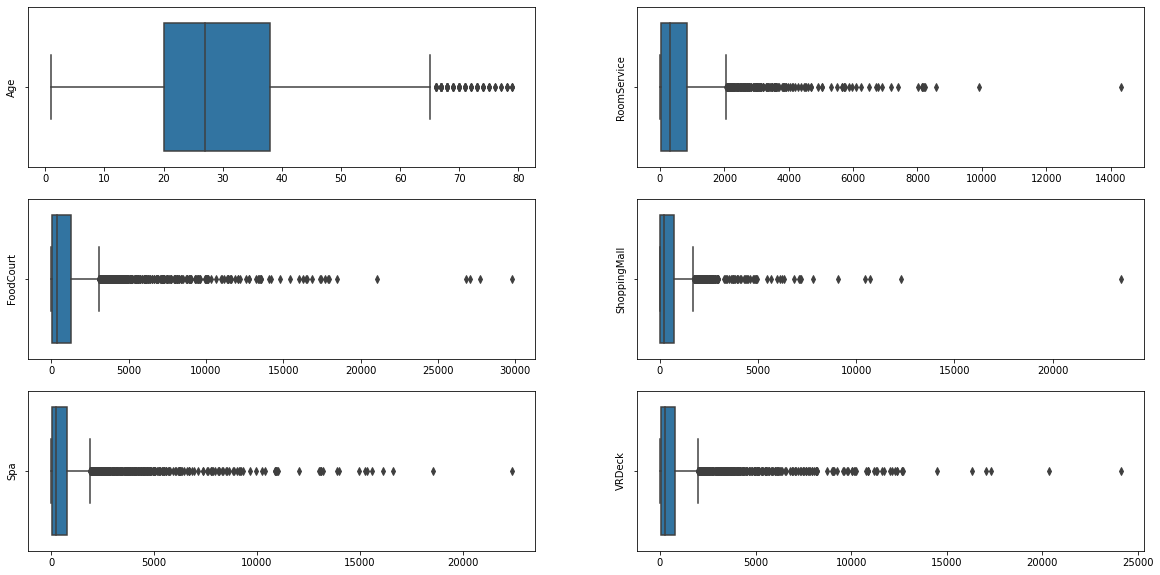

In [6]:
fig = plt.figure(figsize = (20, 10))
cont = 1
for i in range(len(data.dtypes)):
    if data.dtypes[i] == 'float64':
        p = fig.add_subplot(3, 2, cont)
        #We plot only !=0 values to see true outliers
        sns.boxplot(data[data[data.columns[i]] != 0][data.columns[i]])
        p.set_ylabel(data.columns[i])
        p.set_xlabel('')
        cont+=1

In [7]:
#Excluding what I consider true outliers
data = data[(data['RoomService'] < 14000) | (pd.isna(data['RoomService']))]
data = data[(data['ShoppingMall'] < 20000)| (pd.isna(data['ShoppingMall']))]
data = data[(data['Spa'] < 20000)| (pd.isna(data['Spa']))]
data = data[(data['VRDeck'] < 20000)| (pd.isna(data['VRDeck']))]
#data
data.shape

(8688, 14)

## Generating new features
In this section we will be adding some new features to our dataset (inferred from the ones we already have) and we will also be modifying some of them to fit our model correctly.

In [8]:
data = data.set_index('PassengerId')
test = test.set_index('PassengerId')
data['Transported'] = data['Transported'].map({True: 1, False: 0})                
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8509.000000,8507.000000,8505.000000,8480.000000,8506.000000,8500.000000,8688.000000
mean,28.821366,223.097332,455.763433,171.035731,308.535269,299.800118,0.503798
std,14.483233,649.135976,1604.345238,549.297028,1111.425817,1095.155945,0.500014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,46.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,79.000000,9920.000000,29813.000000,12253.000000,18572.000000,17306.000000,1.000000


In [9]:
# df with all data except name (ASSUMIING name has no impact on the output)
df =  data.drop(['Name'] , axis=1)
# creating new columns from PassengerId and Cabin columns
# new column group
df['Group'] = df.index.str[:4]
df['Group'] = df.Group.astype(int)
# new column number in group
df['Number'] = df.index.str[-2:]
df['Number'] = df.Number.astype(int)
# new column Deck
df['Deck'] = df.Cabin.str[0]
# new column NumCabin
df['NumCabin'] = df.Cabin.str[2:-2]
# new column Side
df['Side'] = df.Cabin.str[-1]
df = df.drop('Cabin', axis = 1)

# SAME CHANGES FOR TEST
# df with all data except name (ASSUMIING name has no impact on the output)
test =  test.drop(['Name'] , axis=1)
# creating new columns from PassengerId and Cabin columns
# new column group
test['Group'] = test.index.str[:4]
test['Group'] = test.Group.astype(int)
# new column number in group
test['Number'] = test.index.str[-2:]
test['Number'] = test.Number.astype(int)
# new column Deck
test['Deck'] = test.Cabin.str[0]
# new column NumCabin
test['NumCabin'] = test.Cabin.str[2:-2]
# new column Side
test['Side'] = test.Cabin.str[-1]
test = test.drop('Cabin', axis = 1)


## Null values detection
We wil now proceed to identify null values and replace them with some values that make sense according to the data we have.

In [10]:
df.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             182
VRDeck          188
Transported       0
Group             0
Number            0
Deck            198
NumCabin        198
Side            198
dtype: int64

In [11]:
def fillnull(df):
    notest = 'Transported' in df.columns
    for i in range(len(df.columns)):
        if(df.dtypes[i] == float):
            if notest:
                df[df.columns[i]] = df[df.columns[i]].fillna(df.groupby(['Group','Transported'])[df.columns[i]].transform('mean'))
            df[df.columns[i]] = df[df.columns[i]].fillna(df.groupby(['Group'])[df.columns[i]].transform('mean'))
            if notest:
                df[df.columns[i]] = df[df.columns[i]].fillna(df.groupby(['Transported'])[df.columns[i]].transform('mean'))
            df[df.columns[i]].fillna(df[df.columns[i]].mean(), inplace=True)
        else:
            #I need to figure out how to replace null values with the mode of their groups in cathegorical columns as i do with
            #the mean in numeric columns
            if notest:
                df.dropna(inplace = True)
            else:
                df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mode()[0])
    print(df.isnull().sum())

fillnull(df)
fillnull(test)

df['CryoSleep'] = df['CryoSleep'] ==True
df['VIP'] = df['VIP'] ==True

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Group           0
Number          0
Deck            0
NumCabin        0
Side            0
dtype: int64
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group           0
Number          0
Deck            0
NumCabin        0
Side            0
dtype: int64


In [12]:
df['NumCabin'] = df.NumCabin.astype(int)
test['NumCabin'] = test.NumCabin.astype(int)

## Exploration of cleaned data
Making a quick analysis of the variables correlation can be useful to make some decisions (as dimensionality reduction) although we are not doing it this time.

In [13]:
df.corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Number,NumCabin
CryoSleep,1.000000,-0.081616,-0.081991,-0.255296,-0.210736,-0.228295,-0.206760,-0.202074,0.461527,-0.001321,0.067032,-0.034324
Age,-0.081616,1.000000,0.097015,0.071015,0.132863,0.041587,0.119488,0.105814,-0.080058,-0.004654,-0.132945,-0.136444
VIP,-0.081991,0.097015,1.000000,0.027327,0.137363,0.014792,0.068167,0.131470,-0.039366,0.016436,-0.006199,-0.107136
RoomService,-0.255296,0.071015,0.027327,1.000000,-0.014246,0.061803,0.011314,-0.021277,-0.247884,-0.004661,-0.026164,-0.009587
FoodCourt,-0.210736,0.132863,0.137363,-0.014246,1.000000,-0.012529,0.204956,0.216543,0.055874,-0.007658,0.026422,-0.186870
ShoppingMall,-0.228295,0.041587,0.014792,0.061803,-0.012529,1.000000,0.022670,-0.000840,0.010710,0.020402,-0.040198,0.005841
Spa,-0.206760,0.119488,0.068167,0.011314,0.204956,0.022670,1.000000,0.158502,-0.223574,-0.012555,0.021460,-0.138462
VRDeck,-0.202074,0.105814,0.131470,-0.021277,0.216543,-0.000840,0.158502,1.000000,-0.210132,0.007302,0.007474,-0.143903
Transported,0.461527,-0.080058,-0.039366,-0.247884,0.055874,0.010710,-0.223574,-0.210132,1.000000,0.025938,0.074286,-0.044888
Group,-0.001321,-0.004654,0.016436,-0.004661,-0.007658,0.020402,-0.012555,0.007302,0.025938,1.000000,0.006562,0.677043


Transported very positively correlated with Cryosleep and negatively correlated RoomService, Spa and VRDeck.

In [14]:
target = df['Transported']
df =  df.drop(['Transported'] , axis=1)

# Creating the model
## Preprocessing

In [15]:
df.dtypes

HomePlanet       object
CryoSleep          bool
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Group             int64
Number            int64
Deck             object
NumCabin          int64
Side             object
dtype: object

In [16]:
features_num = []
features_cat = []

for i in range(len(df.dtypes)):
    if df.dtypes[i] == 'object':
        features_cat.append(df.columns[i])
    else:
        features_num.append(df.columns[i])
        
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [17]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(df, target, stratify=target, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

## Model definition: 6 Neural Networks
There are many supervised learning models we can apply to this problem. In our case we will be training 6 neural networks defined in a slightly differnt way, and then we will be blending their predictions (with a simple average of the 6) to make our final prediction.

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
#We define as many models as we want, im going to do 6 simple neural networks
#using to hidden layers varying the number of neurons in each layer and the
#activation function (using variations of relu)
models = []
#MODEL 1
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)
#MODEL 2
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)
#MODEL 3
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation= keras.layers.LeakyReLU(alpha=0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)
#MODEL 4
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation= keras.layers.LeakyReLU(alpha=0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)
#MODEL 5
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(64, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation=keras.layers.PReLU()),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)

#MODEL 6
model =  keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(128, activation='selu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation=keras.layers.PReLU()),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
     layers.Dense(128, activation= keras.layers.LeakyReLU(alpha=0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
models.append(model)



In [19]:
for model in models:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

histories = []
for model in models:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=256,
        epochs=200,

        callbacks=[early_stopping],
    )
    histories.append(history)


Epoch 1/200
20/20 [==============================] - 2s 26ms/step - loss: 0.5924 - binary_accuracy: 0.7148 - val_loss: 0.5564 - val_binary_accuracy: 0.7995
Epoch 2/200
20/20 [==============================] - 0s 11ms/step - loss: 0.4906 - binary_accuracy: 0.7647 - val_loss: 0.5353 - val_binary_accuracy: 0.8096
Epoch 3/200
20/20 [==============================] - 0s 11ms/step - loss: 0.4594 - binary_accuracy: 0.7785 - val_loss: 0.5161 - val_binary_accuracy: 0.8114
Epoch 4/200
20/20 [==============================] - 0s 11ms/step - loss: 0.4510 - binary_accuracy: 0.7832 - val_loss: 0.4880 - val_binary_accuracy: 0.8161
Epoch 5/200
20/20 [==============================] - 0s 11ms/step - loss: 0.4290 - binary_accuracy: 0.7895 - val_loss: 0.4846 - val_binary_accuracy: 0.8114
Epoch 6/200
20/20 [==============================] - 0s 11ms/step - loss: 0.4271 - binary_accuracy: 0.7990 - val_loss: 0.4617 - val_binary_accuracy: 0.8167
Epoch 7/200
20/20 [==============================] - 0s 11ms/ste

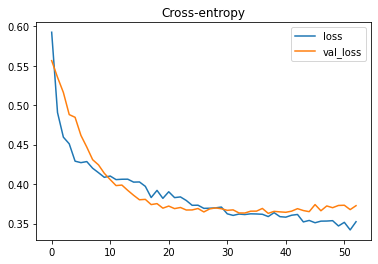

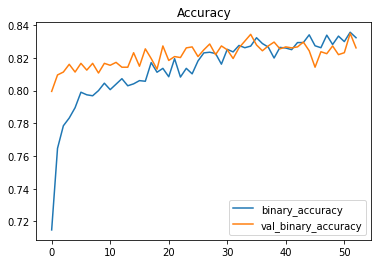

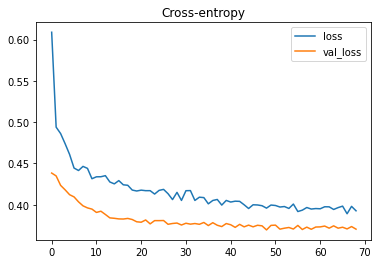

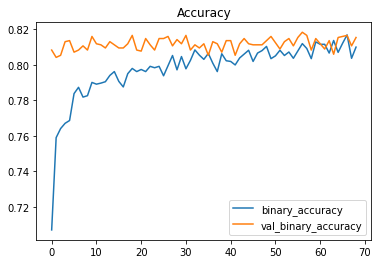

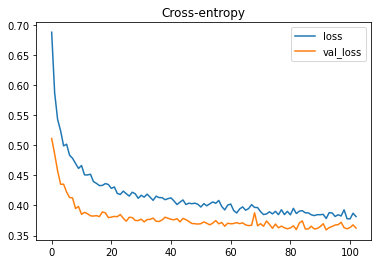

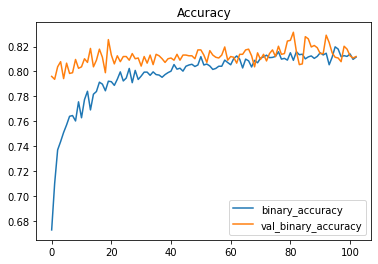

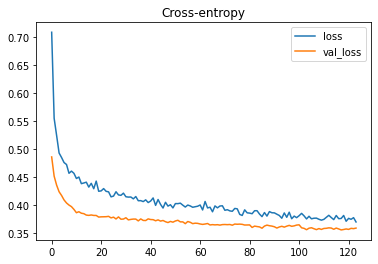

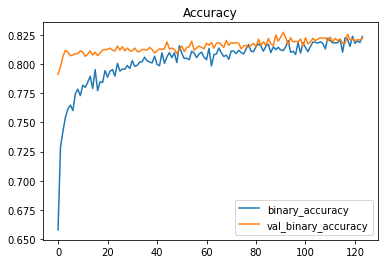

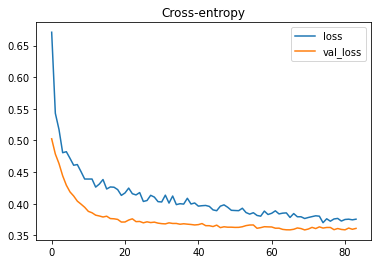

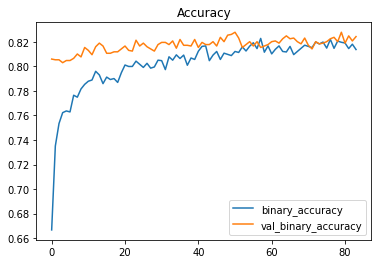

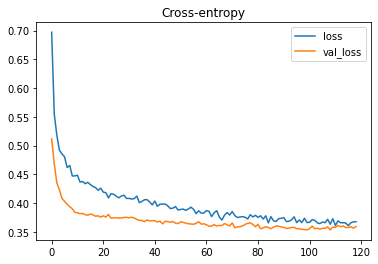

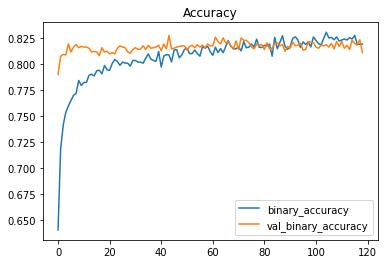

In [20]:
for history in histories:
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
    history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

## Making Predictions

In [21]:
test_trans = preprocessor.fit_transform(test)
predictions = pd.DataFrame()
for i in range(len(models)):
    y_pred = models[i].predict(test_trans)
    pred = []
    for element in y_pred:
        pred.append(element[0])
    predictions[i] = pred
predictions[1200:1225]


,0,1,2,3,4,5
1200,0.243525,0.258638,0.194213,0.233212,0.265843,0.209213
1201,0.980715,0.964281,0.987302,0.986694,0.991017,0.991502
1202,0.989087,0.986450,0.994120,0.996809,0.991997,0.995804
1203,0.960558,0.968446,0.968479,0.985142,0.976008,0.971149
1204,0.707218,0.689471,0.603451,0.618798,0.660702,0.581904
1205,0.334971,0.519081,0.485249,0.396523,0.476700,0.416341
1206,0.359258,0.424287,0.286708,0.301836,0.295647,0.222317
1207,0.977126,0.973643,0.991315,0.991167,0.988512,0.995174
1208,0.551515,0.657304,0.466674,0.528765,0.408983,0.395867
1209,0.092450,0.166450,0.095511,0.111010,0.075000,0.083249


### Blending predicitons with mean

In [22]:
predictions['final_prediction'] = predictions.mean(axis=1)
predictions

,0,1,2,3,4,5,final_prediction
0,0.385570,0.436884,0.340562,0.390304,0.346925,0.392589,0.382139
1,0.030007,0.007648,0.017134,0.016948,0.021029,0.019259,0.018671
2,0.998580,0.994784,0.999337,0.998743,0.998971,0.999507,0.998320
3,0.998709,0.987981,0.995703,0.997530,0.995209,0.998893,0.995671
4,0.450101,0.473520,0.427112,0.484812,0.390847,0.509243,0.455939
...,...,...,...,...,...,...,...
4272,0.428390,0.712689,0.563736,0.518854,0.583854,0.405481,0.535501
4273,0.905179,0.710435,0.734080,0.783857,0.888516,0.883601,0.817611
4274,0.984445,0.969023,0.980712,0.969170,0.956007,0.980106,0.973244
4275,0.906307,0.799761,0.801754,0.787989,0.791344,0.875520,0.827112


In [23]:
f = open ('/kaggle/working/submission.csv','w')
f.write('PassengerId,Transported\n')
for i in range(len(y_pred)):
    f.write(test.index[i])
    f.write(',')
    f.write(str(predictions['final_prediction'][i] > 0.5))
    f.write('\n')
f.close()